# $f_s$ from $\tau_1$

#### Imports and constants

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import time, sys
from IPython.display import clear_output
import datetime
from tqdm.notebook import tqdm
import tensorflow.keras.backend as K
from matplotlib.pyplot import figure
%matplotlib notebook
#plt.rcParams['figure.figsize'] = [16, 6]

########## CONFIG ##########
INPUT = 'tau1'
OUTPUT = 'fs'
TITLE = 'tau1-fs-unet'
NOISE_STDDEV = [0, 1e-2]
############################


NPY_DIR = '/npy-6000-backup/'
#NPY_DIR = '/mnt/2022-datos-fuel/npy-6000-backup/'
RESULTS_DIR = './results/'
MODEL_FILE = '/model/' + TITLE +'.h5'

def standarize(data, mean, std):
    return (data - mean) / std

def destandarize(data, mean, std):
    return (data * std) + mean

def mae_destandarize(y_true, y_pred):
    y_true_d = destandarize(y_true, y_mean, y_std)
    y_pred_d = destandarize(y_pred, y_mean, y_std)
    return K.mean(K.abs(y_pred_d - y_true_d))

def mae_percentage(y_true, y_pred):
    y_true_d = destandarize(y_true, y_mean, y_std)
    y_pred_d = destandarize(y_pred, y_mean, y_std)
    mae = K.mean(K.abs(y_pred_d - y_true_d))
    return (mae * 100) / y_mean

def predict(data):
    return destandarize(model.predict(standarize(data, x_mean, x_std)), y_mean, y_std)

def predict_single(data):
    data_map = standarize(data, x_mean, x_std)
    pred = model.predict(np.expand_dims(data_map, axis=0))[0]
    return destandarize(pred, y_mean, y_std)

def predict(data):
    assert data.ndim > 1
    data_s = standarize(data, x_mean, x_std)
    if data_s.ndim == 2:
        data_s = np.expand_dims(data_s, axis=0)
        pred = model.predict(data_s)[0]
    else:
        pred = model.predict(data_s)
    return destandarize(pred, y_mean, y_std)

def save_results(data, name):
    try:
        os.mkdir(RESULTS_DIR)
    except:
        pass
    try:
        os.mkdir(os.path.join(RESULTS_DIR, TITLE))
    except:
        pass
    dir_name = os.path.join(RESULTS_DIR, TITLE, name)
    try:
        os.mkdir(dir_name)
    except:
        pass
    for i in tqdm(range(data.shape[0]), total=data.shape[0], desc=name, unit=' files'):
        np.savetxt(os.path.join(dir_name, name + '_' + str(i) + '.dat'), data[i], delimiter='\n')

def add_noise(data, rng):
    assert np.size(NOISE_STDDEV) == 1 or np.size(NOISE_STDDEV) == 2
    if np.size(NOISE_STDDEV) == 1:
        data += rng.normal(0, NOISE_STDDEV, data.shape)
    else:
        s = rng.uniform(NOISE_STDDEV[0], NOISE_STDDEV[1], len(data))
        for i, d in enumerate(data):
            d += rng.normal(0, s[i], d.shape)
    return data

In [2]:
x = np.load(os.path.join(NPY_DIR, INPUT + '.npy'))
y = np.load(os.path.join(NPY_DIR, OUTPUT + '.npy'))

#####
x = x[:]
y = y[:]
#####

x_mean = np.mean(x[:].mean())
x_std = np.mean(x[:].std())

y_mean = np.mean(y[:].mean())
y_std = np.mean(y[:].std())

##### NOISE
x = add_noise(x, np.random.RandomState(0))
if 'tau' in INPUT:
    x[x > 1] = 1
#####

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.1, shuffle=True)

x_train = standarize(x_train, x_mean, x_std)
x_valid = standarize(x_valid, x_mean, x_std)

y_train = standarize(y_train, y_mean, y_std)
y_valid = standarize(y_valid, y_mean, y_std)



#################### U-NET
y_train = np.expand_dims(y_train, axis=y_train.ndim)
y_valid = np.expand_dims(y_valid, axis=y_valid.ndim)

x_train = np.expand_dims(x_train, axis=x_train.ndim)
x_valid = np.expand_dims(x_valid, axis=x_valid.ndim)

In [8]:
print(x_train.shape)

(5355, 200, 40, 1)


# U-net

In [10]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add, subtract
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

def conv_block(tensor, filters, kernel_size=3):
    c = Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        activation = 'relu',
        kernel_initializer='he_normal',
        padding='same'
    )(tensor)
    c = BatchNormalization()(c)
    c = Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        activation = 'relu',
        kernel_initializer='he_normal',
        padding='same'
    )(c)
    c = BatchNormalization()(c)
    return c

def deconv_block(tensor, filters, kernel_size=3):
    d = Conv2DTranspose(
        filters=filters,
        kernel_size=kernel_size,
        strides=(2,2),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same'
    )(tensor)
    d = BatchNormalization()(d)
    return d
"""   
def model_unet(input_img, filters=64, dropout=None):
    # CONTRACTING PATH
    # 1st
    c1 = conv_block(input_img, filters=filters)
    c1 = MaxPooling2D(pool_size=2)(mod)
    # 2nd
    c2 = conv_block(mod, filters=2*filters)
    c2 = MaxPooling2D(pool_size=2)(mod)
    # 3rd
    c3 = conv_block(mod, filters=4*filters)
    c3 = MaxPooling2D(pool_size=2)(mod)
    # 3rd
    c4 = conv_block(mod, filters=8*filters)
    c4 = MaxPooling2D(pool_size=2)(mod)
    
    # EXPANDING PATH
"""
    
def model_unet(input_img, depth=4, first_filters=64, kernel_size=3, dropout=None, skip_connection=False):
    # Contracting Path
    c = []
    for i in range(depth):
        if i == 0:
            c.append(conv_block(input_img, filters=(2**i)*first_filters))
        else:
            c.append(MaxPooling2D(pool_size=2)(c[i-1]))
            c[i] = conv_block(c[i], filters=(2**i)*first_filters)
        if dropout is not None:
            c[i] = Dropout(dropout)(c[i])
    # Expanding Path
    e = c[-1]
    for i in reversed(range(depth-1)):
        e = deconv_block(e, filters=(2**i)*first_filters)
        e = concatenate([e, c[i]])
        e = conv_block(e, filters=(2**i)*first_filters)
        if dropout is not None:
            c[i] = Dropout(dropout)(c[i])
        if i == 0:
            e = Conv2D(filters=1, kernel_size=1, activation='linear') (e)
    if skip_connection:
        e = add([input_img, e])
    model = Model(inputs=[input_img], outputs=[e])
    return model

"""
def conv2d_block(input_tensor, n_filters, kernel_size=3 ):
    #Primera capa
    c = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), 
               kernel_initializer="he_normal", padding="same")(input_tensor)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    #Segunda capa
    c = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), 
               kernel_initializer="he_normal", padding="same")(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    return c

def model_unet(input_img, n_filters=8, dropout=0.5):
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3)
    c1 = conv2d_block(c1, n_filters=8, kernel_size=3)
    p1 = MaxPooling2D((2, 2)) (c1)
    #p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=12, kernel_size=3)
    p2 = MaxPooling2D((2, 2)) (c2)
    #p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=24, kernel_size=3)

    u1 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same') (c3)
    u1 = concatenate([u1, c2])
    #u1 = Dropout(dropout)(u1)
    c4 = conv2d_block(u1, n_filters=n_filters*2, kernel_size=3)

    
    u2 = Conv2DTranspose(8, (3, 3), strides=(2, 2), padding='same') (c4)
    u2 = concatenate([u2, c1], axis=3)
    #u2 = Dropout(dropout)(u2)
    c5 = conv2d_block(u2, n_filters=8, kernel_size=3)
    
    outputs = Conv2D(1, (1, 1), activation='linear') (c5)

    model = Model(inputs=[input_img], outputs=[outputs])
    return model
"""

inputs = Input(shape=(x_train.shape[1],x_train.shape[2],1))
#model = model_unet(inputs, n_filters=8, dropout=0.2)
model = model_unet(inputs, depth=4, first_filters=8, skip_connection=True)

#y_train = y_train.reshape(y_train.shape[0], -1)
#y_valid = y_valid.reshape(y_valid.shape[0], -1)

model.compile(
    #optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    #optimizer= 'adam',
    optimizer= Adam(lr = 0.0005),
    loss='mse',
    metrics=['mae', mae_destandarize, mae_percentage]
)

#model.summary()
MODEL_FILE = './models/' + TITLE + '6000' + '.h5'
#log_dir = LOG_DIR_BASE + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tb_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)
es_cb = EarlyStopping(monitor='val_mae_percentage', mode='min', verbose=2, patience=10)
cp_cb = ModelCheckpoint(MODEL_FILE, monitor='val_mae_percentage', verbose=1, save_best_only=True, mode='min')

history = model.fit(x=x_train,
        y=y_train,
        epochs=100,
        #batch_size=64,
        validation_data=(x_valid, y_valid),
        callbacks=[es_cb, cp_cb])

#model.save(MODEL_FILE)
model = tf.keras.models.load_model(
    MODEL_FILE,
    custom_objects={'mae_destandarize': mae_destandarize, 'mae_percentage': mae_percentage}
)

Epoch 1/100
168/168 [==============================] - ETA: 0s - loss: 0.7114 - mae: 0.5325 - mae_destandarize: 8.8362e-07 - mae_percentage: 107.0620
Epoch 00001: val_mae_percentage improved from inf to 78.33608, saving model to ./models/tau1-fs-unet6000.h5
168/168 [==============================] - 56s 335ms/step - loss: 0.7114 - mae: 0.5325 - mae_destandarize: 8.8362e-07 - mae_percentage: 107.0620 - val_loss: 0.3025 - val_mae: 0.3887 - val_mae_destandarize: 6.4654e-07 - val_mae_percentage: 78.3361
Epoch 2/100
168/168 [==============================] - ETA: 0s - loss: 0.1016 - mae: 0.2201 - mae_destandarize: 3.6570e-07 - mae_percentage: 44.3087
Epoch 00002: val_mae_percentage improved from 78.33608 to 68.98444, saving model to ./models/tau1-fs-unet6000.h5
168/168 [==============================] - 56s 336ms/step - loss: 0.1016 - mae: 0.2201 - mae_destandarize: 3.6570e-07 - mae_percentage: 44.3087 - val_loss: 0.1840 - val_mae: 0.3422 - val_mae_destandarize: 5.6935e-07 - val_mae_percent

Epoch 18/100
168/168 [==============================] - ETA: 0s - loss: 0.0284 - mae: 0.1107 - mae_destandarize: 1.8382e-07 - mae_percentage: 22.2718
Epoch 00018: val_mae_percentage improved from 15.62771 to 14.39398, saving model to ./models/tau1-fs-unet6000.h5
168/168 [==============================] - 55s 330ms/step - loss: 0.0284 - mae: 0.1107 - mae_destandarize: 1.8382e-07 - mae_percentage: 22.2718 - val_loss: 0.0109 - val_mae: 0.0715 - val_mae_destandarize: 1.1880e-07 - val_mae_percentage: 14.3940
Epoch 19/100
168/168 [==============================] - ETA: 0s - loss: 0.0239 - mae: 0.1044 - mae_destandarize: 1.7356e-07 - mae_percentage: 21.0284
Epoch 00019: val_mae_percentage improved from 14.39398 to 13.20341, saving model to ./models/tau1-fs-unet6000.h5
168/168 [==============================] - 55s 325ms/step - loss: 0.0239 - mae: 0.1044 - mae_destandarize: 1.7356e-07 - mae_percentage: 21.0284 - val_loss: 0.0090 - val_mae: 0.0656 - val_mae_destandarize: 1.0897e-07 - val_mae_pe

Epoch 53/100
168/168 [==============================] - ETA: 0s - loss: 0.0106 - mae: 0.0792 - mae_destandarize: 1.3156e-07 - mae_percentage: 15.9396
Epoch 00053: val_mae_percentage did not improve from 7.60340
168/168 [==============================] - 55s 328ms/step - loss: 0.0106 - mae: 0.0792 - mae_destandarize: 1.3156e-07 - mae_percentage: 15.9396 - val_loss: 0.0049 - val_mae: 0.0464 - val_mae_destandarize: 7.7155e-08 - val_mae_percentage: 9.3483
Epoch 54/100
168/168 [==============================] - ETA: 0s - loss: 0.0125 - mae: 0.0872 - mae_destandarize: 1.4583e-07 - mae_percentage: 17.6694
Epoch 00054: val_mae_percentage did not improve from 7.60340
168/168 [==============================] - 55s 329ms/step - loss: 0.0125 - mae: 0.0872 - mae_destandarize: 1.4583e-07 - mae_percentage: 17.6694 - val_loss: 0.0045 - val_mae: 0.0435 - val_mae_destandarize: 7.2397e-08 - val_mae_percentage: 8.7718
Epoch 55/100
168/168 [==============================] - ETA: 0s - loss: 0.0134 - mae: 0.

Epoch 71/100
168/168 [==============================] - ETA: 0s - loss: 0.0122 - mae: 0.0857 - mae_destandarize: 1.4273e-07 - mae_percentage: 17.2935
Epoch 00071: val_mae_percentage did not improve from 5.55830
168/168 [==============================] - 55s 329ms/step - loss: 0.0122 - mae: 0.0857 - mae_destandarize: 1.4273e-07 - mae_percentage: 17.2935 - val_loss: 0.0020 - val_mae: 0.0295 - val_mae_destandarize: 4.9046e-08 - val_mae_percentage: 5.9426
Epoch 72/100
168/168 [==============================] - ETA: 0s - loss: 0.0114 - mae: 0.0847 - mae_destandarize: 1.4059e-07 - mae_percentage: 17.0343
Epoch 00072: val_mae_percentage did not improve from 5.55830
168/168 [==============================] - 55s 328ms/step - loss: 0.0114 - mae: 0.0847 - mae_destandarize: 1.4059e-07 - mae_percentage: 17.0343 - val_loss: 0.0024 - val_mae: 0.0335 - val_mae_destandarize: 5.5671e-08 - val_mae_percentage: 6.7453
Epoch 73/100
168/168 [==============================] - ETA: 0s - loss: 0.0120 - mae: 0.

<IPython.core.display.Javascript object>


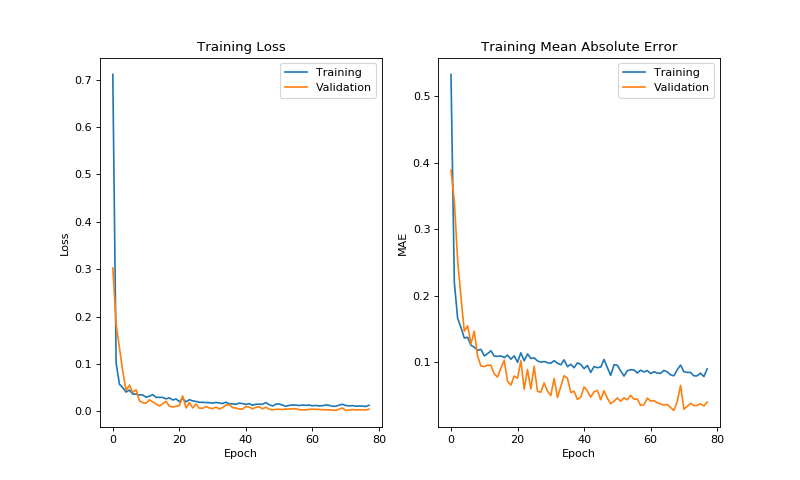

In [43]:
# Loss
figure(figsize=(10,6), dpi=80)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Training Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()

In [5]:
MODEL_FILE = 'model/' + TITLE + '6000' + '.h5'

model = tf.keras.models.load_model(
    MODEL_FILE,
    custom_objects={'mae_destandarize': mae_destandarize, 'mae_percentage': mae_percentage}
)

In [6]:
x = np.load(os.path.join(NPY_DIR, INPUT + '.npy'))
y = np.load(os.path.join(NPY_DIR, OUTPUT + '.npy'))

x_mean = np.mean(x[:].mean())
x_std = np.mean(x[:].std())

y_mean = np.mean(y[:].mean())
y_std = np.mean(y[:].std())

x_test = np.load(os.path.join(NPY_DIR, INPUT + '_test.npy'))
y_test = np.load(os.path.join(NPY_DIR, OUTPUT + '_test.npy'))

##### NOISE
x_test = add_noise(x_test, np.random.RandomState(1))
if 'tau' in INPUT:
    x_test[x_test > 1] = 1
#####

#model = tf.keras.models.load_model(MODEL_FILE)
model = tf.keras.models.load_model(
    MODEL_FILE,
    custom_objects={'mae_destandarize': mae_destandarize, 'mae_percentage': mae_percentage}
)

x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)

y_test_pred = predict(x_test)

model.evaluate(standarize(x_test, x_mean, x_std), standarize(y_test, y_mean, y_std))

x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2])
y_test_pred = y_test_pred.reshape(y_test_pred.shape[0],y_test.shape[1],y_test.shape[2])

#model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 17ms/step - loss: 0.0018 - mean_absolute_error: 0.0273 - mae_destandarize: 4.6168e-08 - mae_percentage: 5.5938


In [7]:
save_results(x_test, INPUT)
save_results(y_test, OUTPUT)
save_results(y_test_pred, OUTPUT + '_pred')

<IPython.core.display.Javascript object>


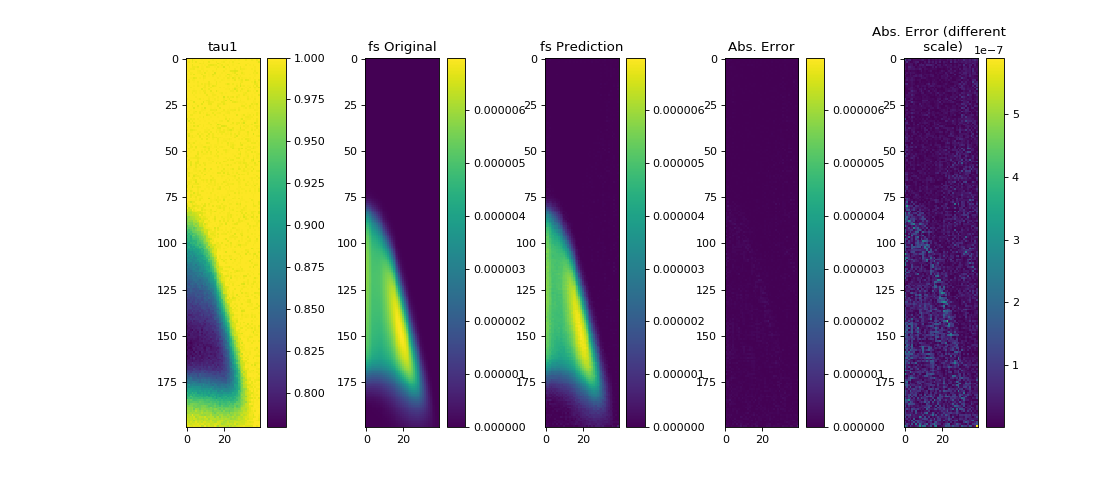

Abs. error max: 5.908466964723463e-07
Abs. error min: 9.237260446019476e-12
Abs. error mean: 4.176422403850933e-08
Abs. error stddev: 4.342654760053856e-08
Abs. error %: 3.3297670309472016


/home/jorge/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


In [10]:
N = 0
figure(figsize=(14,6), dpi=80)
plt.subplot(1, 5, 1)
plt.subplot(1, 5, 1)
plt.imshow(x_test[N], vmin=x_test[N].min(), vmax=x_test[N].max())
plt.title(INPUT)
plt.colorbar()

plt.subplot(1, 5, 2)
plt.imshow(y_test[N], vmin=y_test[N].min(), vmax=y_test[N].max())
plt.title(OUTPUT + ' Original')
plt.colorbar()

plt.subplot(1, 5, 3)
plt.imshow(y_test_pred[N], vmin=y_test[N].min(), vmax=y_test[N].max())
plt.title(OUTPUT + ' Prediction')
plt.colorbar()

abs_err = np.abs(y_test[N] - y_test_pred[N])

plt.subplot(1, 5, 4)
plt.imshow(abs_err, vmin=y_test[N].min(), vmax=y_test[N].max())
plt.title('Abs. Error')
plt.colorbar()

plt.subplot(1, 5, 5)
plt.imshow(abs_err)
plt.title('Abs. Error (different \n scale)')
plt.colorbar()
plt.show()
print('Abs. error max:', abs_err.max())
print('Abs. error min:', abs_err.min())
print('Abs. error mean:', abs_err.mean())
print('Abs. error stddev:', abs_err.std())
print('Abs. error %:', abs_err.mean()*100/y_test[N].mean())

<IPython.core.display.Javascript object>


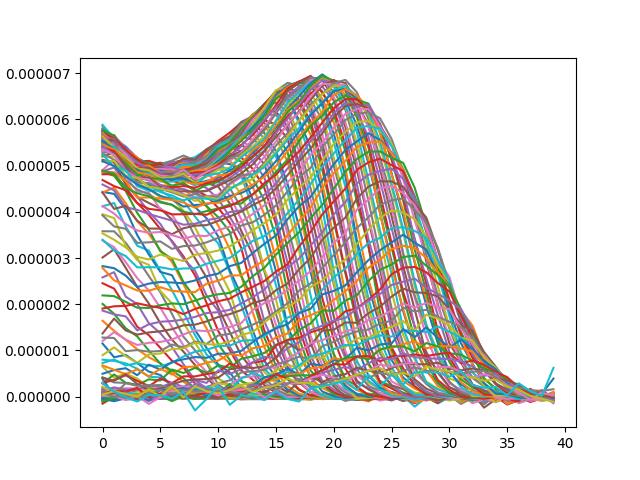

In [11]:
plt.plot(y_test_pred[N].T)

In [16]:
N = 0
plt.subplot(1, 2, 1)
plt.plot(y_test[N].T)
plt.title('Original')
plt.subplot(1, 2, 2)
plt.plot(y_test_pred[N].T)
plt.title('Prediction')

Text(0.5, 1.0, 'Prediction')

In [17]:
N = 0
abs_diff = np.abs(y_test[N] - y_test_pred[N])
plt.plot(abs_diff.T)

In [23]:
y_test[0][1].shape

(40,)

In [19]:
import cv2
plt.imshow(cv2.GaussianBlur(x_test[0], (11,11), 0))

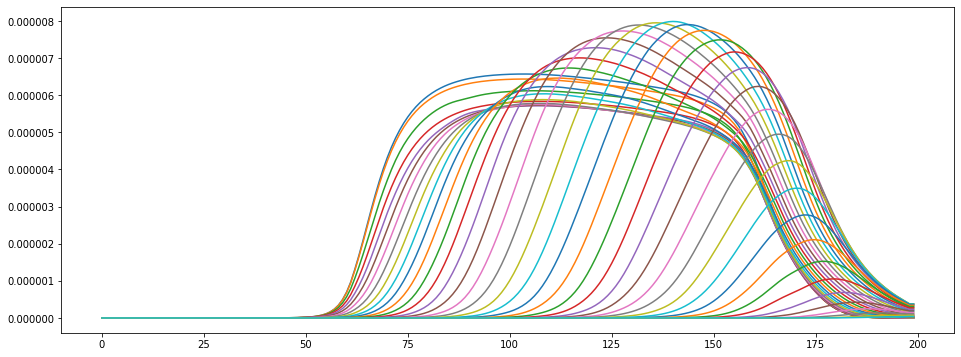

In [25]:
#plt.plot(cv2.GaussianBlur(y_test[0], (25,25), 0))
plt.plot(y_test[1])

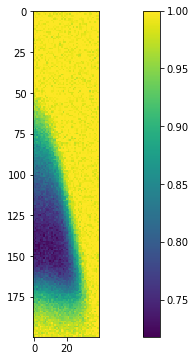

In [26]:
N = 23
plt.imshow(x_test[N])
plt.colorbar()

# EXPERIMENTAL

In [15]:
x = np.load(os.path.join(NPY_DIR, INPUT + '.npy'))
y = np.load(os.path.join(NPY_DIR, OUTPUT + '.npy'))

x_mean = np.mean(x[:].mean())
x_std = np.mean(x[:].std())

y_mean = np.mean(y[:].mean())
y_std = np.mean(y[:].std())

x_exp = np.load(os.path.join(NPY_DIR, 'tau_exp_660.npy'))
         

#model = tf.keras.models.load_model(MODEL_FILE)

x_exp = x_exp.reshape(x_exp.shape[0],x_exp.shape[1],1)

y_exp_pred = predict_single(x_exp)

x_exp = x_exp.reshape(x_exp.shape[0],x_exp.shape[1])

y_exp_pred = y_exp_pred[:,:,0]

##################

fs_deconv = np.load(os.path.join(NPY_DIR, 'fs_deconv_660.npy'))
fs_deconv = fs_deconv/1e6

<IPython.core.display.Javascript object>


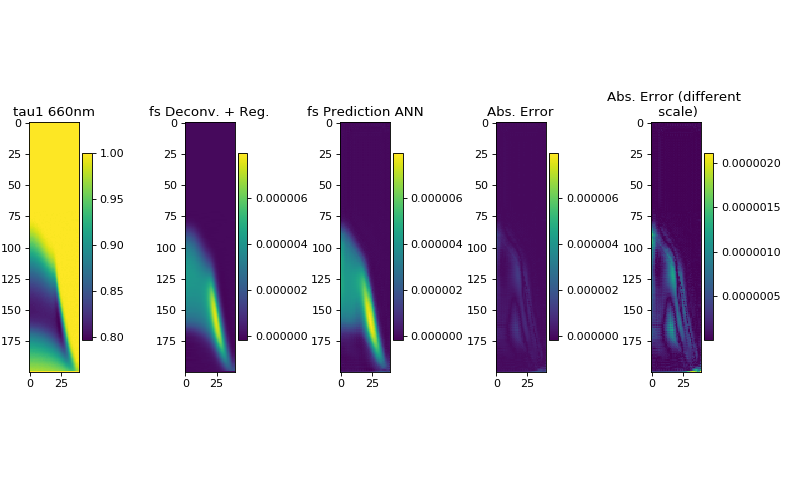

Abs. error max: 2.1067921807116363e-06
Abs. error min: 1.958642640385333e-12
Abs. error mean: 1.522610757152997e-07
Abs. error stddev: 2.3640783192132566e-07
Abs. error %: 14.661765073319577


In [16]:
pmax = np.max([fs_deconv.max(), y_exp_pred.max()])
pmin = np.min([fs_deconv.min(), y_exp_pred.min()])
figure(figsize=(10,6), dpi=80)
plt.subplot(1, 5, 1)
plt.imshow(x_exp, vmin=x_exp.min(), vmax=x_exp.max())
plt.title(INPUT+ str(' 660nm'))
plt.colorbar()

plt.subplot(1, 5, 2)
plt.imshow(fs_deconv, vmin=pmin, vmax=pmax)
plt.title(OUTPUT + ' Deconv. + Reg.')
plt.colorbar()

plt.subplot(1, 5, 3)
plt.imshow(y_exp_pred, vmin=pmin, vmax=pmax)
plt.title(OUTPUT + ' Prediction ANN')
plt.colorbar()

abs_err = np.abs(fs_deconv - y_exp_pred)

plt.subplot(1, 5, 4)
plt.imshow(abs_err, vmin=pmin, vmax=pmax)
plt.title('Abs. Error')
plt.colorbar()

plt.subplot(1, 5, 5)
plt.imshow(abs_err)
plt.title('Abs. Error (different \n scale)')
plt.colorbar()
plt.tight_layout()
print('Abs. error max:', abs_err.max())
print('Abs. error min:', abs_err.min())
print('Abs. error mean:', abs_err.mean())
print('Abs. error stddev:', abs_err.std())
print('Abs. error %:', abs_err.mean()*100/fs_deconv.mean())

In [17]:
def save_results(data, name):
    try:
        os.mkdir(RESULTS_DIR)
    except:
        pass
    try:
        os.mkdir(os.path.join(RESULTS_DIR, TITLE))
    except:
        pass
    dir_name = os.path.join(RESULTS_DIR, TITLE, 'experimental')
    try:
        os.mkdir(dir_name)
    except:
        pass
    np.savetxt(os.path.join(dir_name, name + '.dat'), data, delimiter='\n')

save_results(x_exp, 'tau_exp_660')
save_results(fs_deconv, 'fs_deconv_660')
save_results(y_exp_pred, 'fs_ann_660')

# EXPERIMENTAL - ADDED NOISE

In [20]:
x = np.load(os.path.join(NPY_DIR, INPUT + '.npy'))
y = np.load(os.path.join(NPY_DIR, OUTPUT + '.npy'))

x_mean = np.mean(x[:].mean())
x_std = np.mean(x[:].std())

y_mean = np.mean(y[:].mean())
y_std = np.mean(y[:].std())

x_exp = np.load(os.path.join(NPY_DIR, 'tau_exp_660.npy'))
         
MODEL_FILE = './model/' + TITLE + '6000.h5' 

##### NOISE #####
rng = np.random.RandomState(20)
x_exp += rng.normal(0, 1e-2, x_exp.shape)
x_exp[x_exp > 1] = 1
#################
model = tf.keras.models.load_model(
    MODEL_FILE,
    custom_objects={'mae_destandarize': mae_destandarize, 'mae_percentage': mae_percentage}
)
#model = tf.keras.models.load_model(MODEL_FILE)

x_exp = x_exp.reshape(x_exp.shape[0],x_exp.shape[1],1)

y_exp_pred = predict_single(x_exp)

x_exp = x_exp.reshape(x_exp.shape[0],x_exp.shape[1])

y_exp_pred = y_exp_pred[:,:,0]

##################

fs_deconv = np.load(os.path.join(NPY_DIR, 'fs_deconv_660.npy'))
fs_deconv = fs_deconv/1e6

<IPython.core.display.Javascript object>


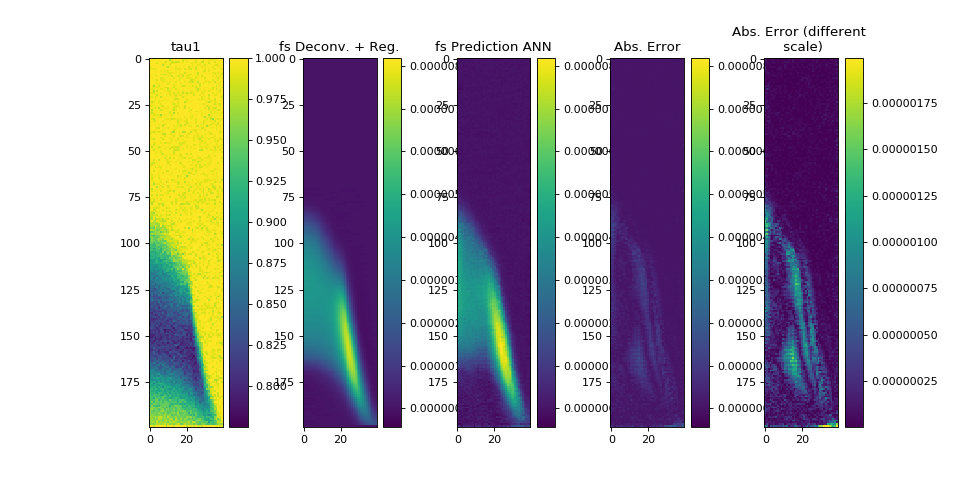

Abs. error max: 1.9942535800510086e-06
Abs. error min: 7.170345219323086e-13
Abs. error mean: 1.6790969193585107e-07
Abs. error stddev: 2.509234849033886e-07
Abs. error %: 16.16862645381623


In [21]:
pmax = np.max([fs_deconv.max(), y_exp_pred.max()])
pmin = np.min([fs_deconv.min(), y_exp_pred.min()])
from matplotlib.pyplot import figure
figure(figsize=(12,6), dpi=80)
plt.subplot(1, 5, 1)
plt.imshow(x_exp, vmin=x_exp.min(), vmax=x_exp.max())
plt.title(INPUT)
plt.colorbar()

plt.subplot(1, 5, 2)
plt.imshow(fs_deconv, vmin=pmin, vmax=pmax)
plt.title(OUTPUT + ' Deconv. + Reg.')
plt.colorbar()

plt.subplot(1, 5, 3)
plt.imshow(y_exp_pred, vmin=pmin, vmax=pmax)
plt.title(OUTPUT + ' Prediction ANN')
plt.colorbar()

abs_err = np.abs(fs_deconv - y_exp_pred)

plt.subplot(1, 5, 4)
plt.imshow(abs_err, vmin=pmin, vmax=pmax)
plt.title('Abs. Error')
plt.colorbar()

plt.subplot(1, 5, 5)
plt.imshow(abs_err)
plt.title('Abs. Error (different \n scale)')
plt.colorbar()

print('Abs. error max:', abs_err.max())
print('Abs. error min:', abs_err.min())
print('Abs. error mean:', abs_err.mean())
print('Abs. error stddev:', abs_err.std())
print('Abs. error %:', abs_err.mean()*100/fs_deconv.mean())

In [22]:
def save_results_exp(data, name):
    try:
        os.mkdir(RESULTS_DIR)
    except:
        pass
    try:
        os.mkdir(os.path.join(RESULTS_DIR, TITLE))
    except:
        pass
    dir_name = os.path.join(RESULTS_DIR, TITLE, 'experimental')
    try:
        os.mkdir(dir_name)
    except:
        pass
    np.savetxt(os.path.join(dir_name, name + '.dat'), data, delimiter='\n')

save_results_exp(x_exp, 'tau_exp_660_noise_1e-2')
#save_results_exp(fs_deconv, 'fs_deconv_800')
save_results_exp(y_exp_pred, 'fs_ann_660_noise_1e-2')